# Adding Spatial Metadata to AORC Forcing

**Authors**:  
  - Tony Castronova <acastronova@cuahsi.org>   
  - Irene Garousi-Nejad <igarousi@cuahsi.org>    
  
**Last Updated**: 04.24.2023  

**Description**:  

This notebook demonstrates how to add spatial metadata to the AORC v1.1 forcing data that is stored on [HydroShare's THREDDs](https://thredds.hydroshare.org/thredds/catalog/aorc/data/16/catalog.html). The original AORC v1.1 data contains `x` and `y` dimensions which allows us to slice the gridded data spatially for simple visualization and data analysis purposes. However, adding additional spatially-related metadata (e.g. coordinate reference system) to datasets that only contain `x` and `y` indices can significantly enhance their utility for a wide range of spatial analysis and modeling applications such as: 

- Perform spatial queries: Spatial information allows us to perform location-based queries, which can be help identify patterns or trends in the data that may be specific to certain areas. 
- Conduct spatial analysis: Spatial information enables spatial analysis, such as interpolation, zoning, or overlaying data layers.
- Visualize data on maps: Spatial information allows you to display data on maps, making it easier to understand spatial patterns and relationships in the data.

This notebook demonstrates one method for doing this.

**Software Requirements**

This notebook was developed using the following software and operating system versions.

OS: MacOS Ventura 13.0.1  
> Python: 3.10.0  \
> re: 2.2.1  \
> numpy: 1.24.1  \
> pyproj: 3.4.1  \
> xarray: 0.17.0  \
> rioxarray: 0.13.3  \
> cartopy: 0.21.1  \
> netCDF4: 1.6.1  \
> owslib: 0.27.2  \
> matplotlib: 3.6.2  

OS: Microsoft Windows 11 Pro version 10.0.22621
> Conda: 22.9.0  \
> Python: 3.9.16  \
> re: 2.2.1  \
> numpy: 1.23.5  \
> pyproj: 3.5.0  \
> xarray: 2023.3.01<span style="font-size:12px"><sup>1</sup></span>  \
> rioxarray: 0.14.02<span style="font-size:12px"><sup>2</sup></span>  \
> cartopy: 0.21.13<span style="font-size:12px"><sup>3</sup></span>  \
> netCDF4: 1.6.34<span style="font-size:12px"><sup>4</sup></span>  \
> owslib: 0.24.15<span style="font-size:12px"><sup>5</sup></span> \
> matplotlib: 3.7.1  

<span style="font-size:12px"> <sup>1</sup> If not yet installed, use `conda install xarray -c conda-forge`. </span>   
<span style="font-size:12px"> <sup>2</sup>If not yet installed, use `conda install rioxarray -c conda-forge`. </span>        
<span style="font-size:12px"> <sup>3</sup>If not yet installed, use `conda install cartopy`. Note that we are not using `-c conda-forge` because it gives DLL failed message for some reason. </span>       
<span style="font-size:12px"> <sup>4</sup>If not yet installed, use `conda install netcdf4`. Note that we are not using `-c conda-forge` because it gives DLL failed message for some reason. </span>      
<span style="font-size:12px"> <sup>5</sup>If not yet installed, use `conda install owslib`.   


---

In [1]:
import re
import numpy
import pyproj
import xarray
import rioxarray 
import cartopy.crs as ccrs
from pyproj import Transformer
import matplotlib.pyplot as plt
from owslib.wms import WebMapService

## Load the AORC v1.1 Data and Check its Dimensions

The AORC v1.1 data stored in HydroShare's ThREDDS catalog covers the Great Basin watershed from 2010-2011. The dataset is divided into 12 netCDF files, each containing hourly values of meteorological variables for an entire month of a year. To load a single month of the AORC v1.1 data from HydroShare's THREDDS, you can use the `open_dataset` function from the `xarray` package to do this task. To learn more about `chunks` and `decode_coords` properties that are used when loading the data, please refer to our how to [Query AORC FOrcing Data via HydroShare Thredds](https://github.com/CUAHSI/notebook-examples/blob/main/thredds/query-aorc-thredds.ipynb) jupyter notebook. 

In [2]:
# load a single month of data
ds = xarray.open_dataset('http://thredds.hydroshare.org/thredds/dodsC/aorc/data/v1.1/16/201001.nc',
                         chunks={'time': 10, 'x': 285, 'y':275},
                         decode_coords="all" )
ds

<xarray.Dataset>
Dimensions:         (time: 744, reference_time: 1, x: 855, y: 820)
Coordinates:
    crs             (time) |S64 dask.array<chunksize=(10,), meta=np.ndarray>
  * reference_time  (reference_time) datetime64[ns] 2010-01-01
  * time            (time) datetime64[ns] 2010-01-15T04:00:00 ... 2010-01-14
  * x               (x) float64 -1.93e+06 -1.929e+06 ... -1.077e+06 -1.076e+06
  * y               (y) float64 -3.335e+05 -3.325e+05 ... 4.845e+05 4.855e+05
Data variables:
    LQFRAC          (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(10, 275, 285), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2010-01-15_04:00:00
    model_initialization_time:       2010-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    history:                         Wed Apr  5 16:20:19 2023: ncks /anvil/da...
    NCO:                             4.7.2
    DODS_EXTRA.Unlimited_Dimension:  time

## Add GeoSpatial Metadata to the AORC Dataset

In order to enhance visualization capabilities, it would be useful to have geographical information in addition to the projected coordinates (`x` and `y` values). With latitude and longitude coordinates available, it would be easier to generate maps and plot data onto them. To create these coordinates in the **WGS84** standard, the following code can be used.

Here we start by creating a mesh grid for the `x` and `y` projected coordinates to ensure the `X` and `Y` arrays have the same size when working with the `pyproj` package. Then, using the `pyproj` packag, we define Lambert Conformal Conic projection system taht was used for the NWM datasets based on the `ds_meta` attributes. We also specify the desired output coordinate system. Finally, we use the `Transformer` function from the `pyproj` package to perform the coordinate transformation and obtain the corresponding geographic coordinates for the given projected inputs.

In [3]:
X, Y = numpy.meshgrid(ds.x.values, ds.y.values)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

Add both geographical and projected coordinate values to the AORC v1.0 dataset (`ds`) by creating DataSet Coordinates. Note that the `lat` and `lon` arrays have two dimensions `(x, y)` but the `x` and `y` arrays only have one dimension.

In this case, each element in the `x` and `y` arrays represents the coordinates of a single point in the grid, while each element in the `lat` and `lon` arrays represents the latitude and longitude values for the corresponding point in the grid. The `lat` and `lon` arrays are thus two-dimensional, with dimensions `(x, y)`, because they contain the latitude and longitude values for each point in the grid.

This type of arrangement is common in geospatial data analysis, where it is often necessary to work with regularly spaced grids of data that have associated geographic coordinates. The `x` and `y` arrays provide the location of each point in the grid, while the `lat` and `lon` arrays provide the corresponding latitude and longitude values.

In [4]:
ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))

## Visualization

In order to validate our workflow for integrating geospatial information into the AORC v1.0 datasets, we have selected the incoming downward longwave radiation (`LWDOWN`) estimates for the initial time step from `ds`. Additionally, we have included the Great Basin watersheds shapefile using the `OWSLib` package to verify and ensure that the AORC v1.1 is correctly located in the appropriate geospatial context. The `OWSLib` package is a Python library utilized for working with Open Geospatial Consortium (OGC) web services, such as Web Map Service (WMS). It offers a range of classes and methods that enable the querying, manipulation, and visualization of geospatial data from OGC web services.

To facilitate the creation of maps and geospatial visualizations in Python, we have utilized the `cartopy` package, which provides a simple means of accomplishing this task.

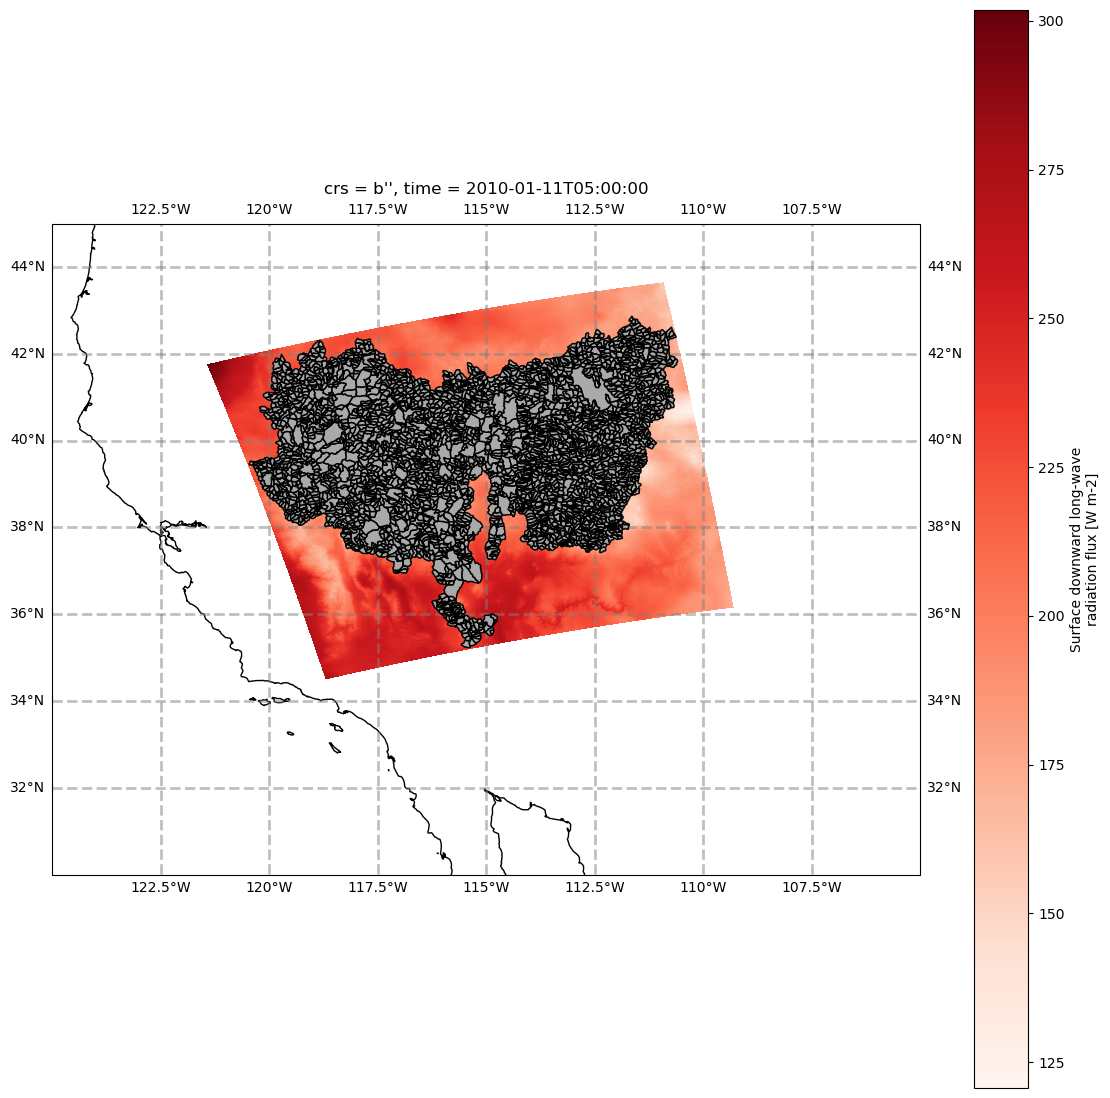

In [5]:
plt.figure(figsize=(14, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# WMS for GB shapefile
gb_wms = 'https://geoserver.hydroshare.org/geoserver/HS-965eab1801c342a58a463f386c9f3e9b/wms'
ax.add_wms(wms=gb_wms,
          layers=['GB_shapefile'],
          zorder=10)

# plot LWDOWN at the first timesteop
ds.isel(time=1).LWDOWN.plot(
               ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat",
               zorder=2,
               cmap='Reds')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.set_ylim([30, 45])
ax.set_xlim([-125, -105])
ax.set_aspect('equal')
ax.coastlines()

plt.show()

For more AORC visualization examples, please check the `query-aorc-thredds.ipynb` notebook available on [CUAHSI Notebook Example GitHub](https://github.com/CUAHSI/notebook-examples/tree/main/thredds).